In [6]:
import dill
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from heapq import nlargest

In [7]:
results_dict = {}
for i in range(5):
    with open(f"xz_results_{i}.pkl", "rb") as dill_file:
        results_dict[f"xz_{i}"] = dill.load(dill_file)
    with open(f"sch_results_{i}.pkl", "rb") as dill_file:
        results_dict[f"sch_{i}"] = dill.load(dill_file)

In [3]:

# * Obtains average tolerance threshold from XZ-method runs.

averages = []
for i in range(5):
    result = results_dict[f"xz_{i}"]
    for j in range(100):
        averages.append(np.mean([result[j].graph.nodes[node]['object'].tolerance_threshold for node in result[j].graph.nodes if result[j].graph.nodes[node]['object'] != None and result[j].graph.nodes[node]['object'].tolerance_threshold != None]))
np.mean(averages)

0.3961503279960033

In [11]:

# * Empty node degree centrality analysis (do empty nodes congregate in high-degree areas?)

dc_ratios = []
for i in range(5):
    results = results_dict[f"xz_{i}"]
    dc_ratio = []
    for k in range(100):
        G = results[k].graph
        dc = nx.degree_centrality(G)
        dc_empty_nodes = []
        dc_all_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] == None:
                dc_empty_nodes.append(dc[node]*len(G))
            dc_all_nodes.append(dc[node]*len(G))
        dc_ratios.append(["Xie & Zhou, Vacancies",i*32,np.mean(dc_empty_nodes)])
        dc_ratios.append(["Xie & Zhou, All Nodes",i*32,np.mean(dc_all_nodes)])
    #dc_ratios[f"Xie & Zhou, {i*32}"]= dc_ratio
    
    results = results_dict[f"sch_{i}"]
    dc_ratio = []
    for k in range(100):
        G = results[k].graph
        dc = nx.degree_centrality(G)
        dc_empty_nodes = []
        dc_all_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] == None:
                dc_empty_nodes.append(dc[node]*len(G))
            dc_all_nodes.append(dc[node]*len(G))
        dc_ratios.append(["Schelling, Vacancies",i*32,np.mean(dc_empty_nodes)])
        dc_ratios.append(["Schelling, All Nodes",i*32,np.mean(dc_all_nodes)])
    #dc_ratios[f"Schelling, {i*32}"] = dc_ratio

df = pd.DataFrame(dc_ratios)
df = df.rename(columns={0:"Method, Group",1:"Densifications",2:"Average Degree"})
df
sns.stripplot(data=df, size=2, x='Densifications', y='Average Degree', hue="Method, Group",palette='colorblind', dodge=True)
plt.show()


In [ ]:

# * Node degree centrality analysis (do tolerant nodes congregate in high-degree areas?)

dc_ratios = []
for i in range(5):
    results = results_dict[f"xz_{i}"]
    dc_tolerant = []
    dc_intolerant = []
    for k in range(100):
        G = results[k].graph
        dc = nx.degree_centrality(G)
        dc_tolerant_nodes = []
        dc_intolerant_nodes = []
        dc_all_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] != None and G.nodes[node]['object'].tolerance_threshold != None:
                if G.nodes[node]['object'].tolerance_threshold >= 0.57:
                    dc_tolerant_nodes.append(dc[node]*len(G))
                elif G.nodes[node]['object'].tolerance_threshold <= 0.07:
                    dc_intolerant_nodes.append(dc[node]*len(G))
                dc_all_nodes.append(dc[node]*len(G))
        dc_ratios.append(["All Nodes", i*32, np.mean(dc_all_nodes)])
        dc_ratios.append(["Tolerant", i*32, np.mean(dc_tolerant_nodes)])
        dc_ratios.append(["Intolerant", i*32, np.mean(dc_intolerant_nodes)])
        
    #dc_ratios[f"Tolerant, {i*32}"]= dc_tolerant
    #dc_ratios[f"Intolerant, {i*32}"]= dc_intolerant

df = pd.DataFrame(dc_ratios)
df = df.rename(columns={0:'Node Type',1:"Densifications",2:"Average Degree"})
#df
sns.violinplot(data=df, size=2, x='Densifications', y='Average Degree', hue='Node Type',palette='colorblind', dodge=True)
plt.tight_layout()
plt.show()

In [496]:

# * Plots change in assortativity (Xie & Zhou)


average_results = []

for i in range(5):
    results = results_dict[f"sch_{i}"]
    array = np.array([(r.attribute_assortativity) for r in results])
    average_array = np.average(array,axis=0)
    average_results.append(["Schelling", i*32, average_array])
    results = results_dict[f"xz_{i}"]
    array = np.array([(r.attribute_assortativity) for r in results])
    average_array = np.average(array,axis=0)
    average_results.append(["Xie & Zhou", i*32, average_array])

df = pd.DataFrame(average_results)
df = df.rename(columns={0:'Tolerances',1:"Densifications",2:"Assortativity"})
df = df.explode("Assortativity")
df['t'] = df.groupby(['Tolerances','Densifications']).cumcount()+1
sns.lineplot(data=df, x='t', y='Assortativity', hue='Densifications', palette='colorblind',style='Tolerances')
plt.xscale('linear')
plt.yscale('logit')
plt.show()

In [530]:
assort_results = []
for i in range(5):
    results = results_dict[f"sch_{i}"]
    array = np.array([(r.attribute_assortativity) for r in results])
    average_array = np.average(array,axis=0)
    speed_1 = (average_array[250]-average_array[0])
    speed_2 = (average_array[4000]-average_array[3750])
    level_1 = average_array[250]
    level_2 = average_array[2500]
    assort_results.append(['Schelling', i*32,speed_1,level_1,speed_2,level_2])
    results = results_dict[f"xz_{i}"]
    array = np.array([(r.attribute_assortativity) for r in results])
    average_array = np.average(array,axis=0)
    speed_1 = (average_array[250]-average_array[0])
    speed_2 = (average_array[4000]-average_array[3750])
    level_1 = average_array[250]
    level_2 = average_array[2500]
    assort_results.append(['Xie & Zhou', i*32,speed_1,level_1,speed_2,level_2])

df = pd.DataFrame(assort_results)
df = df.rename(columns={0:'Tolerances',1:"Densifications",2:fr'$\Delta$ Assortativity (first 250 steps)',3:"Assortativity at t=250",4:fr'$\Delta$ Assortativity (last 250 steps)',5:"Assortativity at t=4000"})
#df = df.explode("Assortativity")
#df['t'] = df.groupby(['Tolerances','Densifications']).cumcount()+1
#sns.scatterplot(data=df, x=fr'$\Delta$ Assortativity (first 250 steps)', y='Assortativity at t=250', hue='Densifications', palette='colorblind',style='Tolerances')
#plt.xscale('linear')
#plt.yscale('logit')
#plt.show()
#sns.scatterplot(data=df, x=fr'$\Delta$ Assortativity (last 250 steps)', y='Assortativity at t=4000', hue='Densifications', palette='colorblind',style='Tolerances')
#plt.show()
sns.scatterplot(data=df, x=fr'$\Delta$ Assortativity (first 250 steps)', y='Assortativity at t=4000', hue='Densifications', palette='colorblind',style='Tolerances')
plt.show()

In [508]:
average(array)

4001

In [ ]:
average_results = []

for i in range(5):
    results = results_dict[f"xz_{i}"]
    array = np.array([(r.attribute_assortativity) for r in results])
    average_array = np.average(array,axis=0)
    average_results.append(["Xie & Zhou", i*32, average_array])

df = pd.DataFrame(average_results)
df = df.rename(columns={0:'Tolerances',1:"Densifications",2:"Assortativity"})
df = df.explode("Assortativity")
df['t'] = df.groupby(['Tolerances','Densifications']).cumcount()+1
sns.lineplot(data=df, x='t', y='Assortativity', hue='Densifications', palette='colorblind',style='Densifications')
plt.show()

In [ ]:

# * Plots n Final Connected Components (Xie & Zhou)

fig, ax  = plt.subplots()

plt_array = []
for i in range(5):
    results = results_dict[f"xz_{i}"]
    plt_array.append(['Xie & Zhou', i*32, list(np.array([(r.n_connected_components[-1]) for r in results]))])
    results = results_dict[f"sch_{i}"]
    plt_array.append(['Schelling', i*32, list(np.array([(r.n_connected_components[-1]) for r in results]))])

df = pd.DataFrame(plt_array)
df = df.rename(columns={0:'Preferences',1:"Densifications",2:"Final Connected Components"})
df = df.explode("Final Connected Components",ignore_index=True)
#df['t'] = df.groupby(['Preferences','Densifications']).cumcount()+1
temp_dict = df.to_dict()
df = pd.DataFrame(temp_dict)
sns.violinplot(data=df, x='Densifications', y='Final Connected Components', hue='Preferences',palette='colorblind', dodge=True, alpha=.3)
plt.show()

In [ ]:
plt_array.shape()

AttributeError: 'list' object has no attribute 'shape'

In [314]:

# * Plots Final CC Size


plt_array = []
for i in range(5):
    results = results_dict[f"xz_{i}"]
    plt_array.append(['Xie & Zhou', i*32, list(np.array([(r.std_cc_size[-1]) for r in results]))])
    results = results_dict[f"sch_{i}"]
    plt_array.append(['Schelling', i*32, list(np.array([(r.std_cc_size[-1]) for r in results]))])

df = pd.DataFrame(plt_array)
df = df.rename(columns={0:'Preferences',1:"Densifications",2:"Final Average Connected Component Size"})
df = df.explode("Final Average Connected Component Size",ignore_index=True)
#df['t'] = df.groupby(['Preferences','Densifications']).cumcount()+1
temp_dict = df.to_dict()
df = pd.DataFrame(temp_dict)
sns.violinplot(data=df, x='Densifications', y='Final Average Connected Component Size', hue='Preferences',palette='colorblind', dodge=True,size=10, alpha=.05,)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:

# * Plots degree distributions by n densifications

array = []

for i in range(5):
    results = results_dict[f"xz_{i}"]
    array.append([i*32, list(np.array([(nx.degree_histogram(r.graph)) for r in results]))])

df = pd.DataFrame(array)
df = df.rename(columns={0:'Densifications',1:"Degree Histograms"})
df = df.explode("Degree Histograms",ignore_index=True)
df = df.explode("Degree Histograms")
df = df.rename(columns={"Degree Histograms":"Frequency"})
df['Degree'] = df.groupby(df.index).cumcount()+1
sns.lineplot(data=df, x='Degree', y='Frequency', hue='Densifications', palette='colorblind',style='Densifications',markers=True)
plt.yscale('log')
plt.show()


C:\Users\deter\AppData\Local\Temp\ipykernel_38492\2264868808.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array.append([i*32, list(np.array([(nx.degree_histogram(r.graph)) for r in results]))])


In [13]:

# * Plots mean degree observed by n densifications.

array = []

for i in range(5):
    results = results_dict[f"xz_{i}"]
    degree_list = [list(r.graph.degree) for r in results]
    degree_list = degree_list[0]
    degree_list = [d[1] for d in degree_list]
    array.append([i*32, degree_list])

df = pd.DataFrame(array)
df = df.rename(columns={0:'Densifications',1:"Degree"})
df = df.explode("Degree")
df['Degree'] = df['Degree'].astype(int)
#df['Degree'] = df.groupby(df.index).cumcount()+1
sns.violinplot(data=df, x='Densifications', y='Degree', hue='Densifications', palette='colorblind', cut=0, dodge=False)
df[df['Densifications']==96].describe()

,Densifications,Degree
count,1024.0,1024.000000
mean,96.0,12.476562
std,0.0,7.578810
min,96.0,2.000000
25%,96.0,4.000000
50%,96.0,12.000000
75%,96.0,17.000000
max,96.0,37.000000


In [590]:

# * Draws selected network displays individual color.

plt.figure(figsize=(5,5))
ax = plt.gca()
#ax.set_title("Xie & Zhou, 0 Densifications")
G = results_dict["sch_0"][2].graph
color_map = []
pos = dict((n,n) for n in G.nodes)
for node in G.nodes:
    if G.nodes[node]['object'] == None:
        color_map.append('black')
    elif G.nodes[node]['object'].color == 0:
        color_map.append('red')
    else:
        color_map.append('blue')
nx.draw_networkx_nodes(G, pos = pos, node_size=30, node_color= color_map, ax=ax,edgecolors='grey')
nx.draw_networkx_edges(G, pos=pos, alpha = .3, width = 3, edge_color='grey')
plt.scatter([],[], color='black', label='Vacancy')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.02),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.box(False)
plt.show()

In [41]:
# * Draws selected network displays tolerance.

    #ax.set_title("Xie & Zhou, 0 Densifications")
plt.figure(figsize=(5,5))
G = results_dict[f"xz_4"][0].graph
color_map = []
vacancies = []
for node in G.nodes:
    if G.nodes[node]['object'] == None:
        vacancies.append(node)
for node in vacancies:
    G.remove_node(node)
pos = dict((n,n) for n in G.nodes)
#pos = nx.kamada_kawai_layout(G)
for node in G.nodes:
    if G.nodes[node]['object'] == None:
        color_map.append('violet')
    elif G.nodes[node]['object'].tolerance_threshold != None:
        tol = G.nodes[node]['object'].tolerance_threshold
        if tol <= .07:
            color_map.append(plt.cm.PiYG(0.07))
        elif tol <= .21:
            color_map.append(plt.cm.PiYG(.21))
        elif tol <= .36:
            color_map.append(plt.cm.PiYG(.36))
        elif tol <= .57:
            color_map.append(plt.cm.PiYG(.57))
        else:
            color_map.append(plt.cm.PiYG(.99))
    else:
        color_map.append('blue')
nx.draw_networkx_nodes(G, pos=pos, node_size=20, node_color= color_map,edgecolors='grey')
nx.draw_networkx_edges(G, pos=pos, alpha = .5, width = 2, edge_color='grey')
for v in [[0,0.07],[.07,0.21],[.21,0.36],[.36,0.57],[.99,1.00]]:
    plt.scatter([],[], c=[plt.cm.PiYG(v[0]/1)],label=fr'$\epsilon \leq {v[1]}$')
plt.scatter([],[], color='blue', label='Non-Guttman')
plt.scatter([],[], color='violet', label='Vacancy')
plt.box(False)
plt.show()


In [38]:
for v in [[0,0.07],[.07,0.21],[.21,0.36],[.36,0.57],[.99,1.00]]:
    plt.scatter([],[], c=[plt.cm.PiYG(v[0]/1)],label=fr'$\epsilon \leq {v[1]}$')
plt.scatter([],[], color='blue', label='Non-Guttman')


plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.15),
          ncol=1, fancybox=False, shadow=False)
plt.box(False)
plt.axis('off')
plt.show()

In [546]:

# * Results table

col_heads_xz = ['Densifications', 'Mean Assortativity', 'Std Assortativity', 'Mean Connected Components', 'Std Connected Components', 'Mean Vacancy Degree Centrality', 'Std Vacancy Degree Centrality','Mean T Node Degree Centrality', 'Std T Node Degree Centrality','Mean I Node Degree Centrality','Std I Node Degree Centrality']
col_heads_sch = ['Densifications', 'Mean Assortativity', 'Std Assortativity', 'Mean Connected Components', 'Std Connected Components', 'Mean Vacancy Degree Centrality', 'Std Vacancy Degree Centrality']
xz_df = pd.DataFrame(columns=col_heads_xz)
sch_df = pd.DataFrame(columns=col_heads_sch)
for i in range(5):
    results = results_dict[f"xz_{i}"]
    densifications = int(i * 32)
    mean_assortativity = np.mean([(r.attribute_assortativity[-1]) for r in results])
    std_assortativity = np.std([(r.attribute_assortativity[-1]) for r in results])
    mean_cc = np.mean([(r.n_connected_components[-1]) for r in results])
    std_cc = np.std([(r.n_connected_components[-1]) for r in results])
    mean_graph_vacancy_dc = []
    for k in range(100):
        G = results[k].graph
        dc = nx.degree_centrality(G)
        dc_empty_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] == None:
                dc_empty_nodes.append(dc[node])
        mean_graph_vacancy_dc.append(np.mean(dc_empty_nodes))
    mean_population_vacancy_dc = np.mean(mean_graph_vacancy_dc)
    std_population_vacancy_dc = np.std(mean_graph_vacancy_dc)

    mean_graph_T_dc = []
    mean_graph_I_dc = []
    for k in range(100):
        G = results[k].graph
        dc = nx.degree_centrality(G)
        dc_tolerant_nodes = []
        dc_intolerant_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] != None and G.nodes[node]['object'].tolerance_threshold != None:
                if G.nodes[node]['object'].tolerance_threshold >= 0.57:
                    dc_tolerant_nodes.append(dc[node])
                elif G.nodes[node]['object'].tolerance_threshold <= 0.07:
                    dc_intolerant_nodes.append(dc[node])
        mean_graph_T_dc.append(np.mean(dc_tolerant_nodes))
        mean_graph_I_dc.append(np.mean(dc_intolerant_nodes))
    mean_population_T_dc = np.mean(mean_graph_T_dc)
    std_population_T_dc = np.std(mean_graph_T_dc)
    mean_population_I_dc = np.mean(mean_graph_I_dc)
    std_population_I_dc = np.std(mean_graph_I_dc)

    xz_df.loc[len(xz_df.index)] = [densifications, mean_assortativity, std_assortativity, mean_cc, std_cc, mean_population_vacancy_dc, std_population_vacancy_dc, mean_population_T_dc, std_population_T_dc, mean_population_I_dc, std_population_I_dc]


for i in range(5):
    results = results_dict[f"sch_{i}"]
    densifications = int(i * 32)
    mean_assortativity = np.mean([(r.attribute_assortativity[-1]) for r in results])
    std_assortativity = np.std([(r.attribute_assortativity[-1]) for r in results])
    mean_cc = np.mean([(r.n_connected_components[-1]) for r in results])
    std_cc = np.std([(r.n_connected_components[-1]) for r in results])
    mean_graph_vacancy_dc = []
    for k in range(100):
        G = results[k].graph
        dc = nx.degree_centrality(G)
        dc_empty_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] == None:
                dc_empty_nodes.append(dc[node])
        mean_graph_vacancy_dc.append(np.mean(dc_empty_nodes))
    mean_population_vacancy_dc = np.mean(mean_graph_vacancy_dc)
    std_population_vacancy_dc = np.std(mean_graph_vacancy_dc)


    sch_df.loc[len(sch_df.index)] = [densifications, mean_assortativity, std_assortativity, mean_cc, std_cc, mean_population_vacancy_dc, std_population_vacancy_dc]

In [596]:
#col_heads_xz = ['Densifications', 'Mean Assortativity', 'Std Assortativity', 'Mean Connected Components', 'Std Connected Components', 'Mean Vacancy Degree Centrality', 'Std Vacancy Degree Centrality',#'Mean T Node Degree Centrality', 'Std T Node Degree Centrality','Mean I Node Degree Centrality','Std I Node Degree Centrality']
#col_heads_sch = ['Densifications', 'Mean Assortativity', 'Std Assortativity', 'Mean Connected Components', 'Std Connected Components', 'Mean Vacancy Degree Centrality', 'Std Vacancy Degree Centrality']
#xz_df = pd.DataFrame(columns=col_heads_xz)
#sch_df = pd.DataFrame(columns=col_heads_sch)
result_list = []
for i in range(0,5):
    results = results_dict[f"xz_{i}"]
    densifications = int(i * 32)
    name = 'Xie & Zhou'
    for r in results:
        G = r.graph
        dc = nx.degree_centrality(G)
        dc_empty_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] == None:
                dc_empty_nodes.append(dc[node])
        mean_vacancy_dc = np.mean(dc_empty_nodes)
        dc = nx.degree_centrality(G)
        dc_tolerant_nodes = []
        dc_intolerant_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] != None and G.nodes[node]['object'].tolerance_threshold != None:
                if G.nodes[node]['object'].tolerance_threshold >= 0.57:
                    dc_tolerant_nodes.append(dc[node])
                elif G.nodes[node]['object'].tolerance_threshold <= 0.07:
                    dc_intolerant_nodes.append(dc[node])
        mean_T_dc =np.mean(dc_tolerant_nodes)
        mean_I_dc = np.mean(dc_intolerant_nodes)


        result_list.append([name, densifications, r.attribute_assortativity[-1],r.n_connected_components[-1], mean_vacancy_dc, mean_T_dc, mean_I_dc])

    results = results_dict[f"sch_{i}"]
    densifications = int(i * 32)
    name = 'Schelling'
    mean_graph_vacancy_dc = []
    for r in results:
        G = r.graph
        dc = nx.degree_centrality(G)
        dc_empty_nodes = []
        for node in G.nodes:
            if G.nodes[node]['object'] == None:
                dc_empty_nodes.append(dc[node])
        mean_vacacny_dc = np.mean(dc_empty_nodes)
        result_list.append([name, densifications, r.attribute_assortativity[-1],r.n_connected_components[-1], mean_vacacny_dc, None, None])



In [621]:
df = pd.DataFrame(result_list,columns=['Tolerances','Densifications','Assortativity','Connected Components','Vacancy Degree Centrality', 'Tolerant Node Degree Centrality', 'Intolerant Node Degree Centrality'])

df2 = df.melt(['Tolerances','Densifications','Assortativity','Connected Components','Vacancy Degree Centrality'],var_name='Type',value_name='Degree Centrality').copy()
df2['Type'] = df2['Type'].apply(lambda x: 'Intolerant' if x == 'Intolerant Node Degree Centrality' else 'Tolerant')

In [622]:
sns.violinplot(data=df2, x='Densifications', y='Degree Centrality', hue='Type', palette='colorblind', cut=0, dodge=True)
plt.show()

In [601]:
df

,Tolerances,Densifications,Assortativity,Connected Components,Vacancy Degree Centrality,Tolerant Node Degree Centrality,Intolerant Node Degree Centrality
0,Xie & Zhou,0,0.846793,3,0.003802,0.003820,0.003740
1,Xie & Zhou,0,0.850486,3,0.003863,0.003778,0.003733
2,Xie & Zhou,0,0.853509,4,0.003840,0.003798,0.003696
3,Xie & Zhou,0,0.859837,1,0.003824,0.003748,0.003767
4,Xie & Zhou,0,0.818101,3,0.003850,0.003791,0.003753
...,...,...,...,...,...,...,...
995,Schelling,128,0.929851,3,0.014686,NaN,NaN
996,Schelling,128,0.952383,2,0.013849,NaN,NaN
997,Schelling,128,0.960981,1,0.013525,NaN,NaN
998,Schelling,128,0.960717,1,0.013289,NaN,NaN


In [44]:
graphs = [[nx.grid_2d_graph(20,20, periodic=True) for _ in range(100)], [nx.erdos_renyi_graph(400, .01) for _ in range(100)], [nx.barabasi_albert_graph(400, 2) for _ in range(100)], [nx.watts_strogatz_graph(400,4,.1) for _ in range(100)]]
for k in range(len(graphs)):
    print(k)
    means = []
    stds = []
    for l in range(len(graphs[k])):
        hist = nx.degree_histogram(graphs[k][l])
        dist = []
        for i in range(len(hist)):
            for j in range(hist[i]):
                dist.append(i)
        means.append(np.mean(dist))
        stds.append(np.std(dist))
    m_neighbors, std_neighbors = np.mean(means), np.mean(stds)
    print(m_neighbors, std_neighbors)

    means = []
    stds = []
    for _ in range(100):
        buckets = np.zeros(400)
        for i in range(4000):
            buckets[np.random.randint(0,400)] += 1
        means.append(np.mean(buckets))
        stds.append(np.std(buckets))
    print(np.mean(means), np.mean(stds))

    means = []
    stds = []
    for _ in range(100):
        groups = []
        for _ in range(100):
            groups.append(sum(np.random.choice(buckets,size=(max(int(np.random.normal(m_neighbors/10,std_neighbors/10)*10),0)),replace=False)))
        means.append(np.mean(groups))
        stds.append(np.std(groups))
    print(np.mean(means),np.mean(stds))

0
4.0 0.0
10.0 3.16902458764651
40.187999999999995 6.36134574494645
1
3.9821 1.9818984736661736
10.0 3.149741638171246
34.8699 20.280274475927193
2
3.98 4.661476520581191
10.0 3.1537977291431867
41.277699999999996 38.32002397637522
3
4.0 0.6129003727988132
10.0 3.162650515021086
34.91029999999999 9.14228345626295


# Entropy

In [8]:
def measure_entropy(prob_arr):
    log_arr = np.array([np.log2(x) for x in prob_arr])
    shannon = -1* sum([x*y for x,y in list(zip(prob_arr,log_arr))])
    print(f"Shannon: {shannon}")

def discretize(x,bins=50):
    div = bins/100
    buckets = np.arange(0,1,1/bins)
    if x == -1:
        return -1
    elif x == -2:
        return -2
    else:
        for i in range(len(buckets)):
            if x > buckets[i]:
                discrete_x = int((i/div))
        return discrete_x

def process_array(array,xlabel,ylabel):
    for d in array:
        df = pd.DataFrame(d)
        df = df.sort_values(by=0,ascending=False)
        df['Pair'] = "(" + df[0].astype(str) + ", " + df[1].astype(str) + ")"
        probabilities = []
        sorted_symbols = pd.DataFrame([str(sorted((x[1][0],x[1][1]))) for x in df.iterrows()])
        for symbol in set(sorted_symbols[0]):
            relative_freq = sorted_symbols[0].value_counts()[symbol]/len(sorted_symbols[0])
            probabilities.append(relative_freq)
        measure_entropy(probabilities)
        df = df.groupby([0,1]).count().reset_index()
        df['Pair'] = df['Pair'].apply(lambda x: np.log(x))
        df = df.pivot_table(index=0,columns=1,values='Pair')
        #df = df.fillna(0)
        sns.heatmap(df,cmap='rocket_r',square=True).invert_yaxis()
        plt.xlabel(f"{ylabel}")
        plt.ylabel(f"{xlabel}")
        plt.show()
        #sns.heatmap(df.corr(),cmap='Spectral_r',square=True).invert_yaxis()
        #plt.xlabel(f"{ylabel}")
        #plt.ylabel(f"{ylabel}")
        #lt.show()
        

In [49]:
graphs = [[nx.grid_2d_graph(20,20, periodic=True) for _ in range(100)], [nx.erdos_renyi_graph(400, .01) for _ in range(100)], [nx.barabasi_albert_graph(400, 2) for _ in range(100)], [nx.watts_strogatz_graph(400,4,.1) for _ in range(100)]]
degree_array = [[],[],[],[],[]]
pair_array = [[],[],[],[],[]]
for k in range(len(graphs)):
    for l in range(len(graphs[k])):
        G = graphs[k][l]

        for node in G.nodes:
            degree = G.degree(node)
            degree_array[k].append(degree)
            for nbr in G.neighbors(node):
                nbr_degree = G.degree(nbr)
                pair_array[k].append(str(sorted((degree,nbr_degree))))
    

In [50]:
degree_freq_array = [[],[],[],[],[]]
pair_freq_array = [[],[],[],[],[]]
for i in range(len(degree_array)):
    freq_array = []
    for elem in set(degree_array[i]):
        proportion = degree_array[i].count(elem) / len(degree_array[i])
        freq_array.append(proportion)
    degree_freq_array[i] = freq_array

for i in range(len(pair_array)):
    freq_array = []
    for elem in set(pair_array[i]):
        proportion = pair_array[i].count(elem) / len(pair_array[i])
        freq_array.append(proportion)
    pair_freq_array[i] = freq_array

for arr in degree_freq_array:
    measure_entropy(arr)

for arr in pair_freq_array:
    measure_entropy(arr)

Shannon: -0.0
Shannon: 2.999105639298715
Shannon: 2.516138464352316
Shannon: 1.3214721651588783
Shannon: 0
Shannon: -0.0
Shannon: 5.148017541431519
Shannon: 7.226564862273881
Shannon: 2.160085238477084
Shannon: 0


In [57]:

### * Plots tolerance histogram 

array = []

for i in range(1):
    results = results_dict[f"xz_{i}"]
    G = results[0].graph
    for node in G:
        if G.nodes[node]['object'] != None:
            if G.nodes[node]['object'].tolerance_threshold != None:
                array.append(G.nodes[node]['object'].tolerance_threshold)
df = pd.DataFrame(array)
df = df.rename(columns={0:'Tolerance Threshold'})
sns.histplot(data=df, bins=25)
#plt.xlabel('Tolerance Threshold')
plt.show()

tlist = df['Tolerance Threshold'].apply(discretize).to_list()
pair_list = [tuple(sorted((np.random.choice(tlist),np.random.choice(tlist)))) for _ in range(7567)]
for i in range(int(32*32*.15)):
    tlist.append(-1)
prob_array = []
for val in set(tlist):
    prob_array.append(tlist.count(val)/len(tlist))
pair_prob_array = []
for val in set(pair_list):
    pair_prob_array.append(pair_list.count(val)/len(pair_list))

measure_entropy(prob_array)
measure_entropy(pair_prob_array)

Shannon: 4.847058650911167
Shannon: 8.969872932273288


In [536]:

### * Generate array of pairs (node degree, neighbor degree)

array = [[],[],[],[],[]]
for i in range(5):
    results = results_dict[f"xz_{i}"]
    for r in results:
        G = r.graph
        for node in G.nodes:
            degree = G.degree(node)
            for nbr in G.neighbors(node):
                nbr_degree = G.degree(nbr)
                array[i].append([nbr_degree,degree])

process_array(array,'Neighbor Degree','Node Degree')
   


Shannon: 0.6824073815619667
Shannon: 4.877636216614147
Shannon: 6.312244461516681
Shannon: 7.163569948840402
Shannon: 7.642354847570101


In [9]:

### * Generate array (node tolerance, node neighborhood size)

array = [[],[],[],[],[]]
for i in range(5):
    results = results_dict[f"xz_{i}"]
    for r in results:
        G = r.graph
        for node in G.nodes:
            if G.nodes[node]['object'] != None:
                if G.nodes[node]['object'].tolerance_threshold != None:
                    tol = G.nodes[node]['object'].tolerance_threshold
                else:
                    tol = -1
            else:
                tol = -2
            degree = G.degree(node)
            tol = discretize(tol, bins=25)
            array[i].append([degree,tol])

process_array(array,'Degree','Tolerance')      

Shannon: 5.0300718440951115
Shannon: 6.665235446708947
Shannon: 7.561213970097607
Shannon: 8.134801405928863
Shannon: 8.517105277359018


: 

In [7]:

         
array = [[],[],[],[],[]]
for i in range(5):
    results = results_dict[f"xz_{i}"]
    for r in results:
        G = r.graph
        for node in G.nodes:
            if G.nodes[node]['object'] != None:
                if G.nodes[node]['object'].tolerance_threshold != None:
                    tol = G.nodes[node]['object'].tolerance_threshold
                else:
                    tol = -1
            else:
                tol = -2
            tol = discretize(tol,bins=25)
            node_color = G.nodes[node]['color']
            node_degree = G.degree(node)
            for nbr in G.neighbors(node):
                if G.nodes[nbr]['color'] != G.nodes[node]['color']:
                    if G.nodes[nbr]['object'] != None:
                        if G.nodes[nbr]['object'].tolerance_threshold != None:
                            nbr_tol = G.nodes[nbr]['object'].tolerance_threshold
                        else:
                            nbr_tol = -1
                    else:
                        nbr_tol = -2
                    nbr_tol = discretize(nbr_tol,bins=25)
                    nbr_color = G.nodes[nbr]['color']
                    nbr_degree = G.degree(nbr)
                    array[i].append([tol,nbr_tol])

    
process_array(array,'Neighbor Tolerance','Node Tolerance')

Shannon: 5.841695765766438
Shannon: 6.1551075731955285
Shannon: 6.138038154260999
Shannon: 6.163115557170059
Shannon: 6.253959261175155


In [63]:

### * Generate Shannon entropy of node degree distribution.

array = [[],[],[],[],[]]
for i in range(5):
    results = results_dict[f"xz_{i}"]
    for r in results:
        G = r.graph
        for node in G.nodes:
            degree = G.degree(node)
            array[i].append(degree)
prob_array = [[],[],[],[],[]]
for i in range(5):
    for val in set(array[i]):
        prob_array[i].append(array[i].count(val)/len(array[i]))
for i in range(5):
    print(i)
    measure_entropy(prob_array[i])

0
Shannon: 0.5573926332340278
1
Shannon: 2.300460273501235
2
Shannon: 3.218087634768526
3
Shannon: 3.8049825385805276
4
Shannon: 4.190235070516265


In [276]:
array = [[],[],[],[],[]]
for i in range(5):
    results = results_dict[f"xz_{i}"]
    for r in results:
        G = r.graph
        for node in G.nodes:
            if G.nodes[node]['object'] != None:
                if G.nodes[node]['object'].tolerance_threshold != None:
                    tol = G.nodes[node]['object'].tolerance_threshold
                else:
                    tol = -1
                tol = discretize(tol)
                node_color = G.nodes[node]['color']
                node_degree = G.degree(node)
                for nbr in G.neighbors(node):
                    if G.nodes[nbr]['color'] != G.nodes[node]['color']:
                        if G.nodes[nbr]['object'] != None:
                            if G.nodes[nbr]['object'].tolerance_threshold != None:
                                nbr_tol = G.nodes[nbr]['object'].tolerance_threshold
                            else:
                                nbr_tol = -1
                            nbr_tol = discretize(nbr_tol)
                            nbr_color = G.nodes[nbr]['color']
                            nbr_degree = G.degree(nbr)
                            array[i].append([node_degree,nbr_degree])
process_array(array,'Node Degree','Neighbor Degree')

Shannon: 0.5461050495535906
Shannon: 4.5354520746550255
Shannon: 6.444572054983051
Shannon: 7.240590109365727


KeyboardInterrupt: 

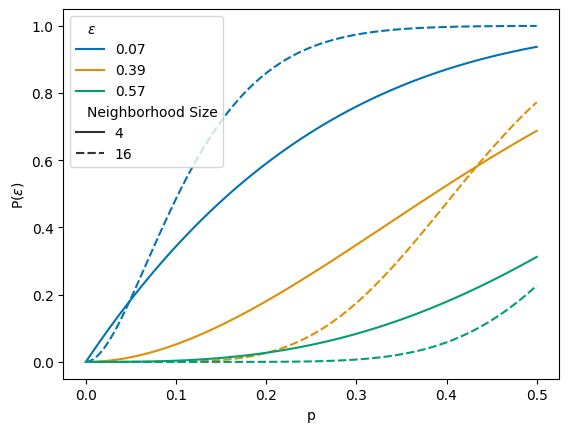

In [5]:
import math
df = pd.DataFrame()
tolerances = [.07,.39,.57]
tolerances = [round(t,2) for t in tolerances]
neighborhoods = np.arange(4,17,12)
results = []
for n in neighborhoods:
    for epsilon in tolerances:
        x = np.linspace(0,.5,100)
        for p in x:
            total = 0
            for k in range(int(np.ceil(n * epsilon)),n+1):
                total += math.comb(n,k)*(p**k)*(1-p)**(n-k)
            results.append([p,total,n,epsilon])
df = pd.DataFrame(results)
df[3] = df[3].astype(float)
df = df.rename(columns={0:"p",1:fr'P($\epsilon$)',2:'Neighborhood Size',3:fr'$\epsilon$'})
sns.lineplot(df, x="p",y=fr'P($\epsilon$)',palette='colorblind',hue=fr'$\epsilon$', style='Neighborhood Size', legend='full',)
plt.show()

In [446]:
import math
df = pd.DataFrame()
tolerances = [.05]
tolerances = [round(t,2) for t in tolerances]
neighborhoods = [4,16]
results = []
for epsilon in tolerances:
    for n in neighborhoods:
        x = np.linspace(0,.5,100)
        for p in x:
            total = 0
            for k in range(int(np.ceil(n * epsilon)),n+1):
                total += math.comb(n,k)*(p**k)*(1-p)**(n-k)
            results.append([p,total,n,epsilon])
df = pd.DataFrame(results)
df[3] = df[3].astype(float)
df = df.rename(columns={0:"p",1:fr'P($\epsilon$)',2:'Neighborhood Size',3:fr'$\epsilon$'})
sns.lineplot(df, x="p",y=fr'P($\epsilon$)',palette='colorblind',hue='Neighborhood Size',style='Neighborhood Size', legend='full')
plt.show()

In [591]:
results_dict["sch_0"][2].graph = results_dict["sch_0"][28].graph